**Problem Scenario:**

The customer always looks forward to specialized treatment, whether shopping on an e-commerce website or watching Netflix. The customer desires content that aligns with their preferences. To maintain customer engagement, companies must consistently provide the most relevant information.

Starting with Spotify, a Swedish audio streaming and media service provider, boasts over 456 million active monthly users, including more than 195 million paid subscribers as of September 2022. The company aims to create cohorts of different songs to enhance song recommendations. These cohorts will be based on various relevant features, ensuring that each group contains similar types of songs.

**Problem Objective:**

As a data scientist, you should perform exploratory data analysis and cluster analysis to create cohorts of songs. The goal is to better understand the various factors that create a cohort of songs

Data wrangling and metrics

In [10]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')


from requests.exceptions import HTTPError


url = 'https://raw.githubusercontent.com/tksundar/cohort_of_songs/refs/heads/master/rolling_stones_spotify.csv'
try:
  raw_data = pd.read_csv(url,skip_blank_lines=True,skipinitialspace=True)
except Exception as e:
  print('File not found , error ',e)
  print('trying to read file locally')
  raw_data = pd.read_csv('rolling_stones_spotify.csv',skip_blank_lines=True,skipinitialspace=True)
  print('File read successfully')
raw_data = raw_data.drop('Unnamed: 0',axis=1)
print(raw_data.shape)
# release_date, id and url do not contribute to our analysys of the given problem
raw_data = raw_data.drop(['release_date','id','uri'],axis=1)
print(raw_data.shape)


(1610, 17)
(1610, 14)


Fix the outliers

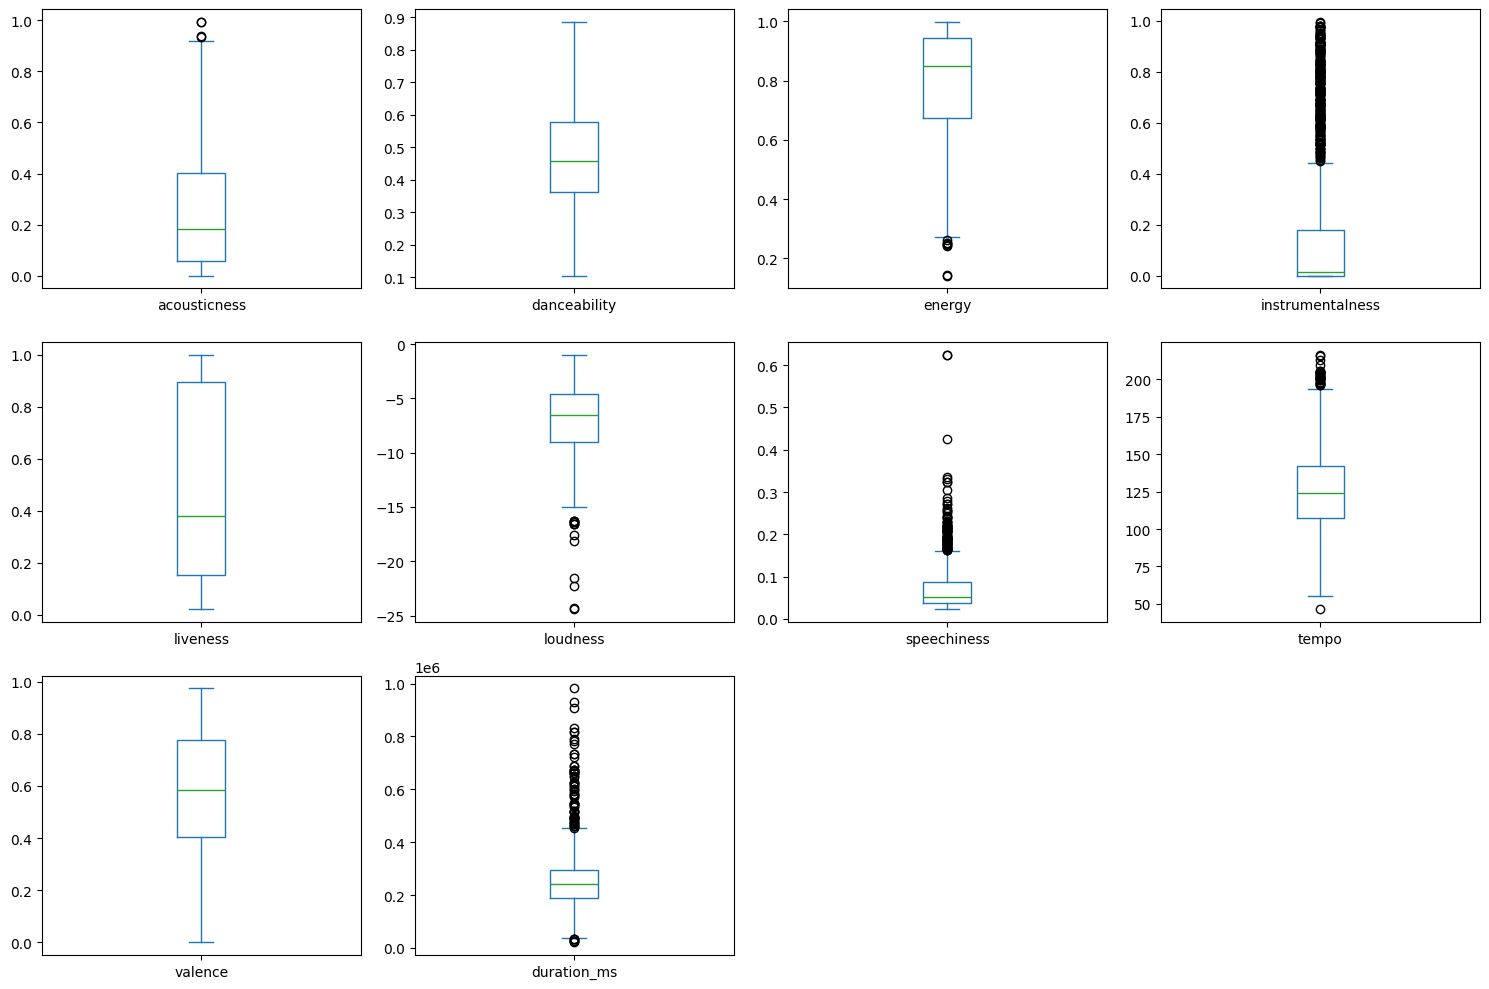

In [12]:
import matplotlib.pyplot as plt
raw_data.select_dtypes(include='number').drop(['track_number','popularity'],axis=1).plot(kind='box',subplots=True,figsize=(15,10), layout= (3,4), sharex=False, sharey=False)
plt.tight_layout()
plt.show()

There are outliers. Lets fix them

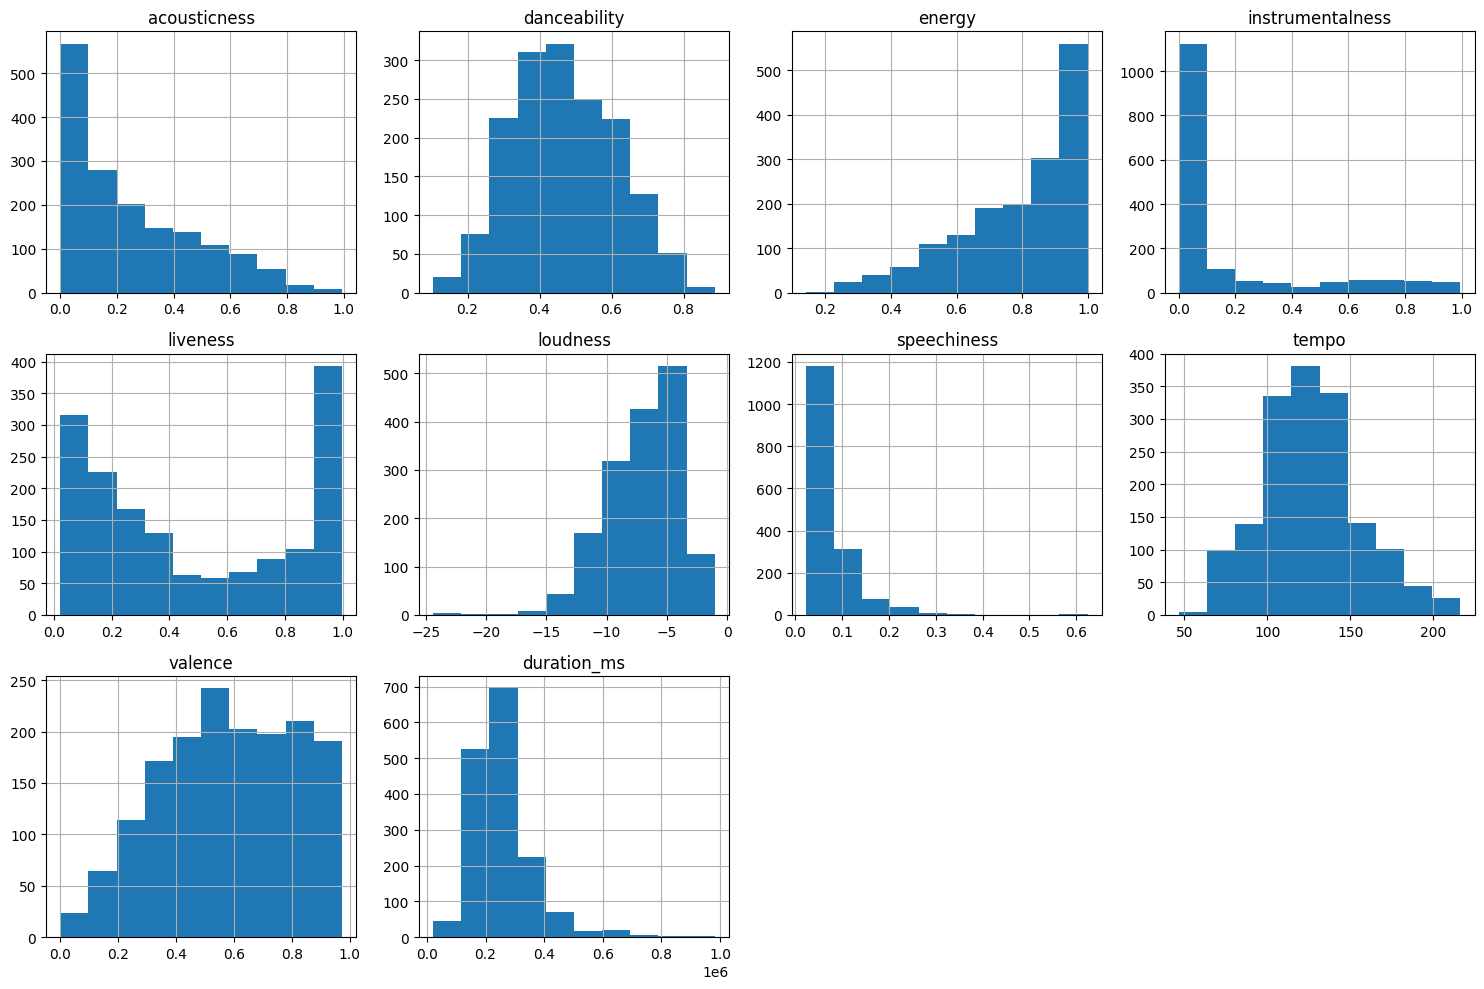

In [13]:
raw_data.select_dtypes(include='number').drop(['track_number','popularity'],axis=1).hist(figsize=(15,10), layout= (3,4), sharex=False, sharey=False)
plt.tight_layout()
plt.show()

Distribution is skewed. We will use median to replace outliers

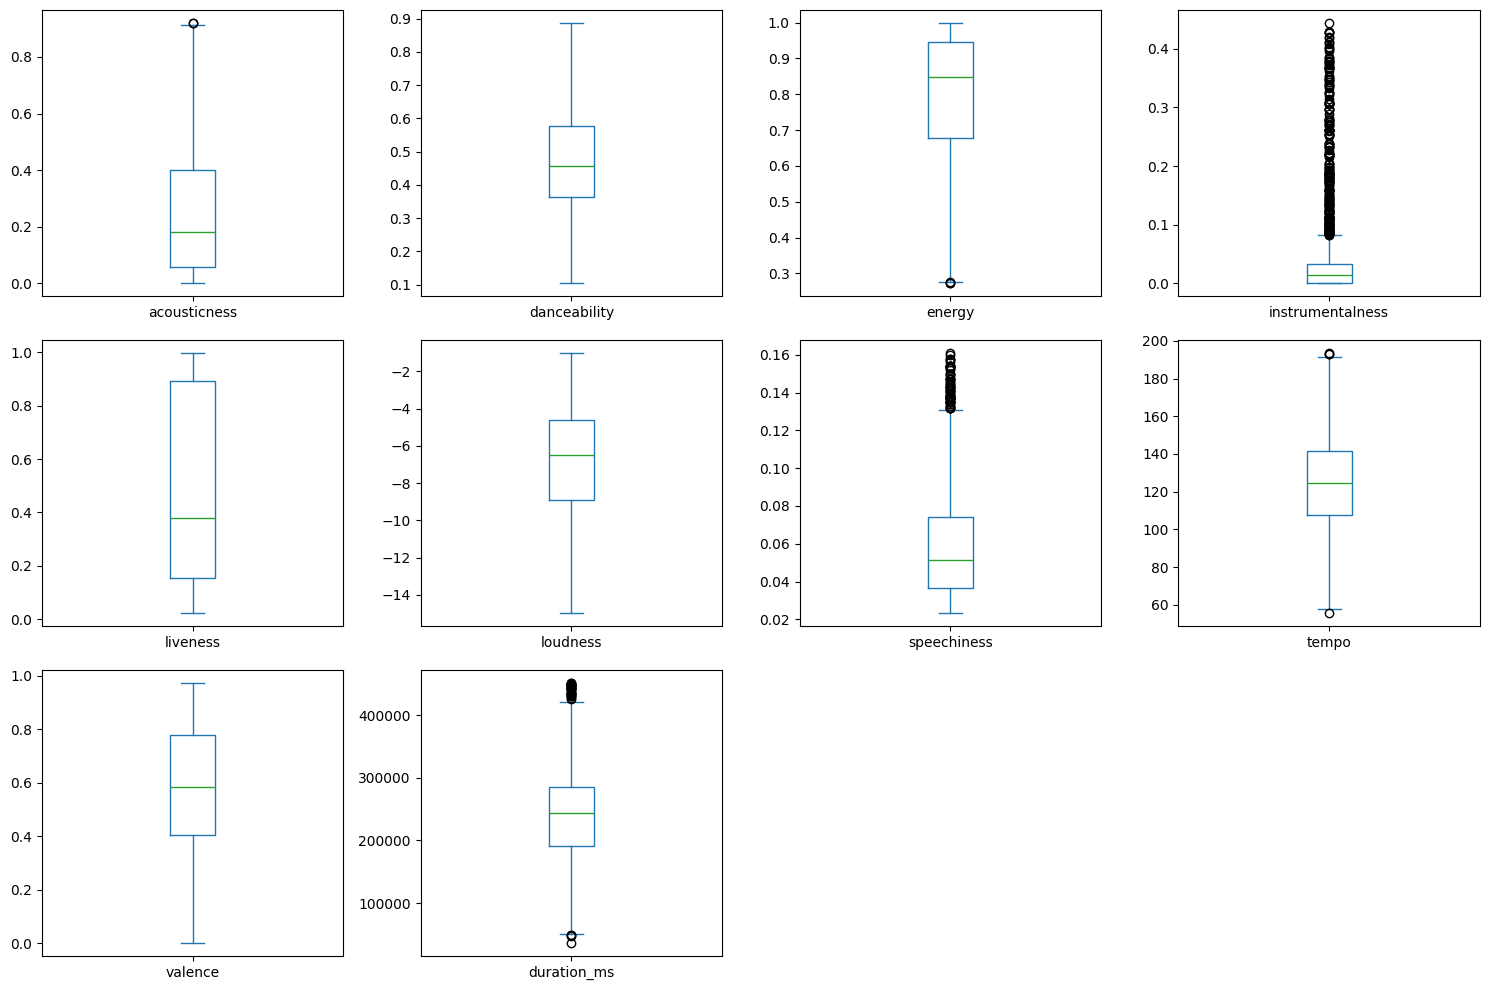

In [14]:
import numpy as np
def detect_outliers_iqr(data):
    data = sorted(data)
    q1 = np.percentile(data, 25)
    q3 = np.percentile(data, 75)
    IQR = q3 - q1
    lwr_bound = q1 - (1.5 * IQR)
    upr_bound = q3 + (1.5 * IQR)
    outliers = []
    for i in data:
        if i < lwr_bound or i > upr_bound:
            outliers.append(i)
    return outliers


def remove_outliers(data, outlier_columns):

  for column in outlier_columns:
      array = data[column]
      outliers = detect_outliers_iqr(array)
      value = np.median(array)
      for i in outliers:
          # for every i(outlier) in array , replace it by value else retain the same array element
          array = np.where(array == i, value, array)
          data[column] = np.asarray(array)

  return data
data = remove_outliers(raw_data,raw_data.select_dtypes(include='number').drop(['track_number','popularity'],axis=1).columns)
data.select_dtypes(include='number').drop(['track_number','popularity'],axis=1).plot(kind='box',subplots=True,figsize=(15,10), layout= (3,4), sharex=False, sharey=False)
plt.tight_layout()
plt.show()

Outliers removed

Get top two albums. We should identify the two albums whose songs have the top two average popularity

Top 2 albums
------------
                          album  popularity
68  Sticky Fingers (Remastered)        53.3
61                   Some Girls        48.1


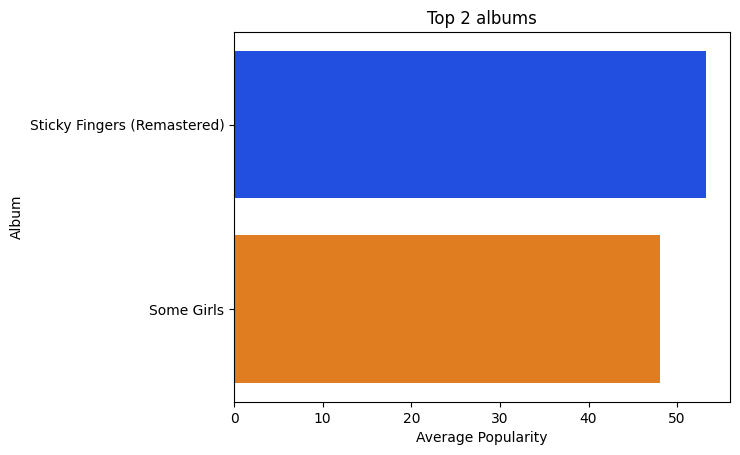

In [15]:
import seaborn as sns

grp_albums = pd.DataFrame(data.groupby('album')['popularity'].mean()).reset_index()
top_2_albums = grp_albums.sort_values(by ='popularity',ascending=False).head(2)
print('Top 2 albums\n------------')
print(top_2_albums)

df = pd.DataFrame(top_2_albums).reset_index()
sns.barplot(data=df,y='album',x='popularity',palette= sns.color_palette("bright"))

plt.xlabel('Average Popularity')
plt.ylabel('Album')
plt.title('Top 2 albums')
plt.show()

Data preprocessing

In [16]:
from sklearn.preprocessing import StandardScaler
#we will exclude track_number from further analysis
numeric_df = data.select_dtypes(include=np.number).drop(['track_number'],axis=1)
scaler = StandardScaler()
scaled_df = pd.DataFrame(scaler.fit_transform( numeric_df),columns=numeric_df.columns )
df = data.loc[:,['name','album','track_number']]
# data containing relevant object columns along with scaled numerio columns
songs_data = pd.concat([df,scaled_df],axis=1)
songs_data.head()


name               album  track_number  \
0   Concert Intro Music - Live  Licked Live In NYC             1   
1   Street Fighting Man - Live  Licked Live In NYC             2   
2           Start Me Up - Live  Licked Live In NYC             3   
3  If You Can't Rock Me - Live  Licked Live In NYC             4   
4            Don’t Stop - Live  Licked Live In NYC             5   

   acousticness  danceability    energy  instrumentalness  liveness  loudness  \
0     -0.739913     -0.041343  1.127016         -0.346610  1.261552 -2.178321   
1      0.839405     -1.007963  0.967267          2.299562  1.344648  0.743649   
2      0.745875     -0.584626  0.990089          4.315117  1.330321  0.695730   
3      1.418399     -0.704571  1.081373         -0.511270  1.155532  0.479915   
4      0.674614     -1.170242  0.990089          0.162107  1.358975  0.637363   

   speechiness     tempo   valence  popularity  duration_ms  
0     1.636763 -0.241965 -2.387590    0.982999    -2.640778  
1     0.525524  0.257175 -1.142678    1.063495     0.137324  
2     1.799701  0.205643 -1.164306    1.063495     0.272974  
3    -0.279392  0.314271 -1.882359    0.902504     0.853225  
4     1.082773  0.222969 -1.627147    0.902504     0.842712

EDA

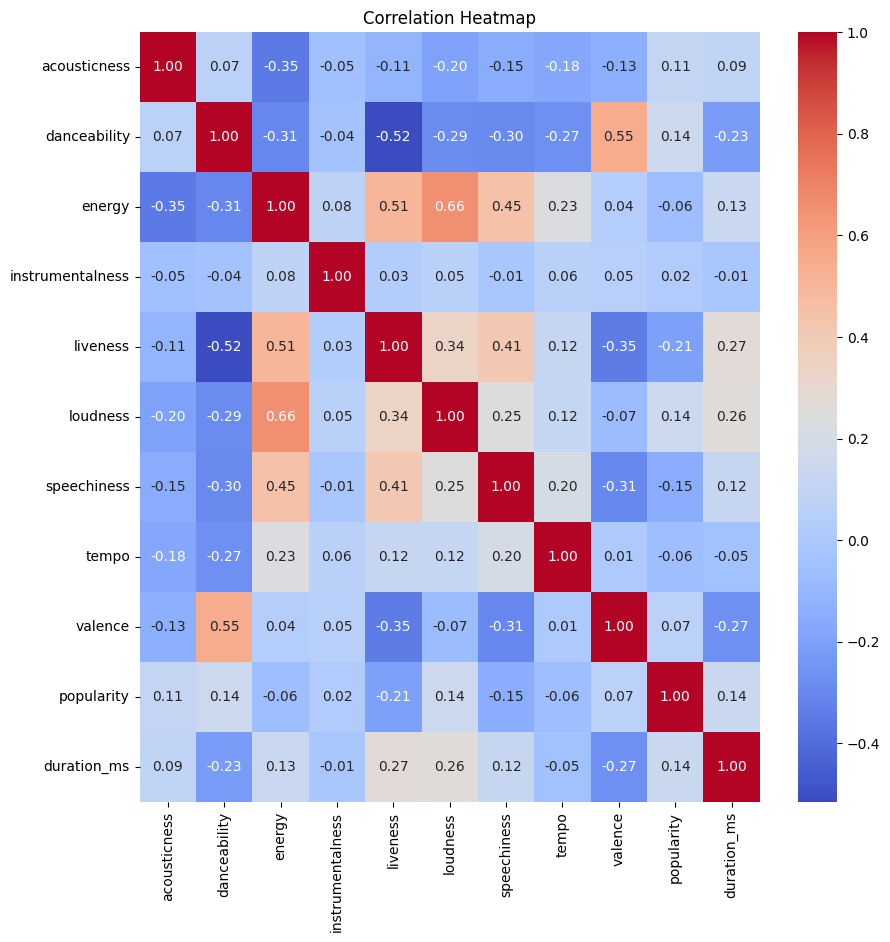

In [17]:
plt.figure(figsize = (10,10))
sns.heatmap(scaled_df.corr(),annot=True,cmap = 'coolwarm',fmt = '0.2f')
plt.title('Correlation Heatmap')
plt.show()



From the heatmap we can see that there are no strong correlations between **popularity** and any one feature of the songs. We however see medium to strong correrlation between features themselves(multicolinear) , such as loudness vs energy, valence vs danceability, liveness vs energy etc. Quite possibly, a combination of these features make a song more or less popular , but what that combination is , is not very obvious.

Lets examine the scatter plots.

<Figure size 1200x1200 with 0 Axes>

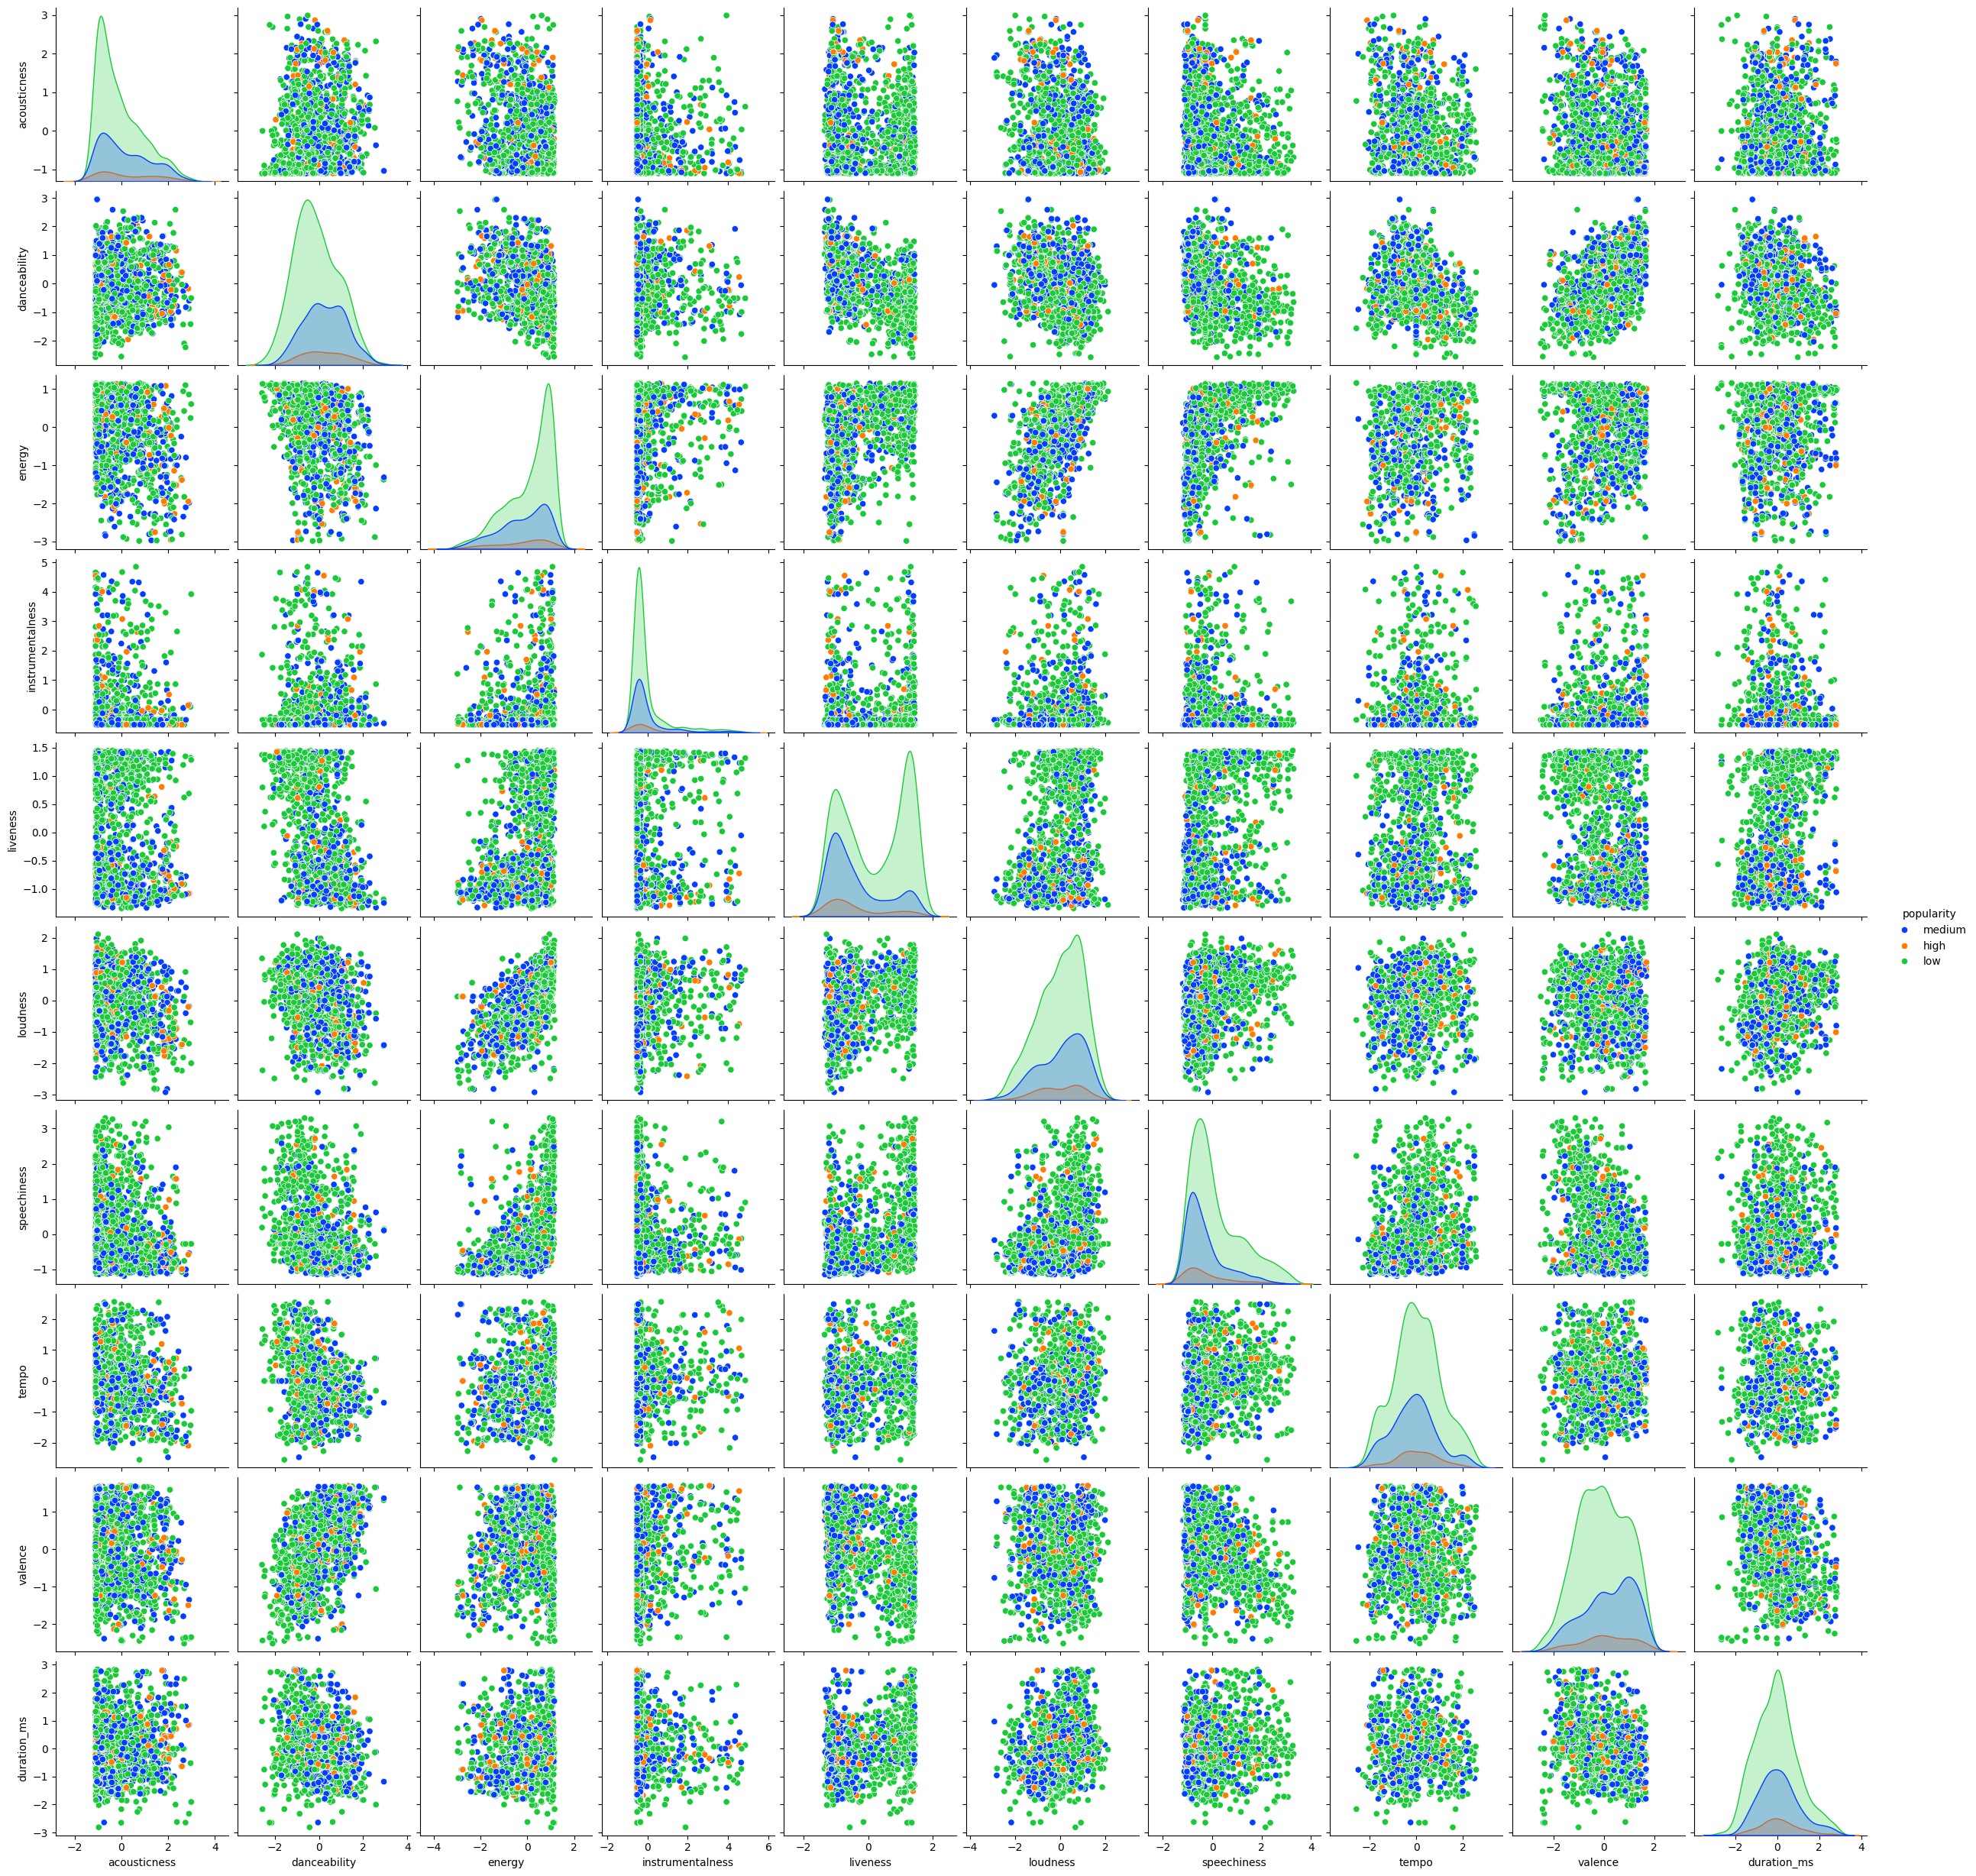

In [18]:
def get(x):
  if 25 < x < 50:
    return 'medium'
  elif x < 25:
    return 'low'
  else:
    return 'high'
plt.figure(figsize=(12,12))
df = scaled_df.loc[:,['acousticness', 'danceability', 'energy', 'instrumentalness', 'liveness', 'loudness', 'speechiness', 'tempo', 'valence', 'duration_ms','popularity' ]]
df['popularity'] = data['popularity'].apply(lambda x: get(x))

sns.pairplot(data=df,hue='popularity',palette=sns.color_palette("bright"))
plt.show()


From the above scatter plot, we can see that the there isnt any obvious cluster than we can identify based on individual features. All we can say from the distribution plots is that the dataset has most songs with **low popularity** and only a few highly popular songs.  We cannot get any meaningful insight without sensible feature extraction

We will use Pricipal Component Decomposition to reduce the dimenaionality to better view the clusters

explained variance ratio: 
[0.27901183 0.14639881 0.12005975 0.09144451 0.08308371 0.06557127
 0.06347046 0.05963686 0.04318077 0.02877146 0.01937058]
cumulative explained variance ratio: 
[0.27901183 0.42541064 0.54547039 0.63691489 0.7199986  0.78556988
 0.84904033 0.9086772  0.95185796 0.98062942 1.        ]


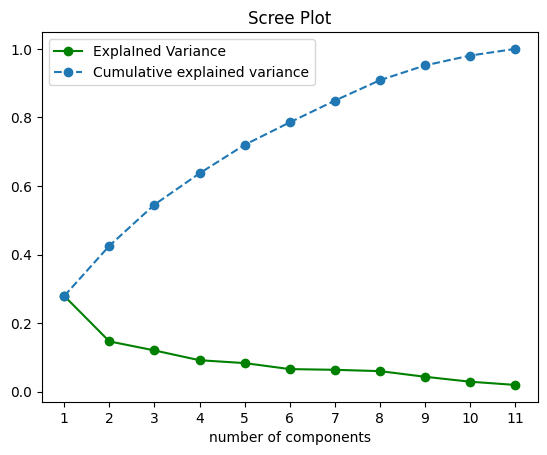

In [19]:
#plot explained variances and their cumulative values
from sklearn.decomposition import PCA

pca = PCA(random_state=123)
pca.fit(scaled_df)
print('explained variance ratio: ')
print(pca.explained_variance_ratio_)
print('cumulative explained variance ratio: ')
print(pca.explained_variance_ratio_.cumsum())
plt.plot(range(1,pca.explained_variance_ratio_.shape[0]+1),pca.explained_variance_ratio_, marker = 'o' , c = 'g', label = 'ExplaIned Variance')
plt.plot(range(1,pca.explained_variance_ratio_.shape[0]+1),pca.explained_variance_ratio_.cumsum(),marker='o',linestyle='--', label = 'Cumulative explained variance')
plt.legend(loc='best')
plt.xlabel('number of components')
plt.xticks(range(1,pca.explained_variance_ratio_.shape[0]+1))
plt.title('Scree Plot')
plt.show()

We can see that PC1 and PC2 together explain only 42% of the total variance. Clearly we need more components. To explain > 80 % of the variance we need at least 7 components ☹

(1610, 7)


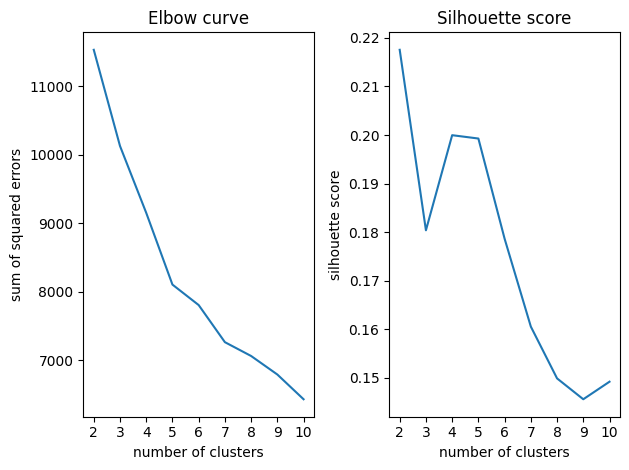

Silhoutte Scores:
 [0.21755470326798768, 0.18037201889984014, 0.19996444427976579, 0.19927756778839292, 0.1786378924090792, 0.16053473417016778, 0.14986473511117734, 0.1455691541307245, 0.1491843805383784]


In [21]:
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans

pca = PCA(n_components=7,random_state=123)
# # we transform the original data agaion with PCA initialized to 7 components
X_pca = pca.fit_transform(scaled_df)
print(X_pca.shape)
sum_squared_errors = []
silhouette_scores = []
max_clusters = 10
for k in range(2,max_clusters+1):
  km = KMeans(n_clusters=k,random_state=123)
  km.fit_transform(X_pca)
  sum_squared_errors.append(km.inertia_)
  labels = km.predict(X_pca)
  silhouette_scores.append(silhouette_score(X_pca,labels))

plt.subplot(1,2,1)
plt.plot(range(2,max_clusters+1),sum_squared_errors)
plt.xticks(range(2,max_clusters+1))
plt.xlabel('number of clusters')
plt.ylabel('sum of squared errors')
plt.title('Elbow curve')

plt.subplot(1,2,2)
plt.plot(range(2,max_clusters+1),silhouette_scores)
plt.xticks(range(2,max_clusters+1))
plt.xlabel('number of clusters')
plt.ylabel('silhouette score')
plt.title('Silhouette score')

plt.tight_layout()
plt.show()

print('Silhoutte Scores:\n',silhouette_scores)

There are elbows at clusters 2 , 5 and 7. The silhoutte scorees indicate that cluster 2 has the best score!!! We will plot the scatteer plot for clusters 2,3,4 and 5 to confirm

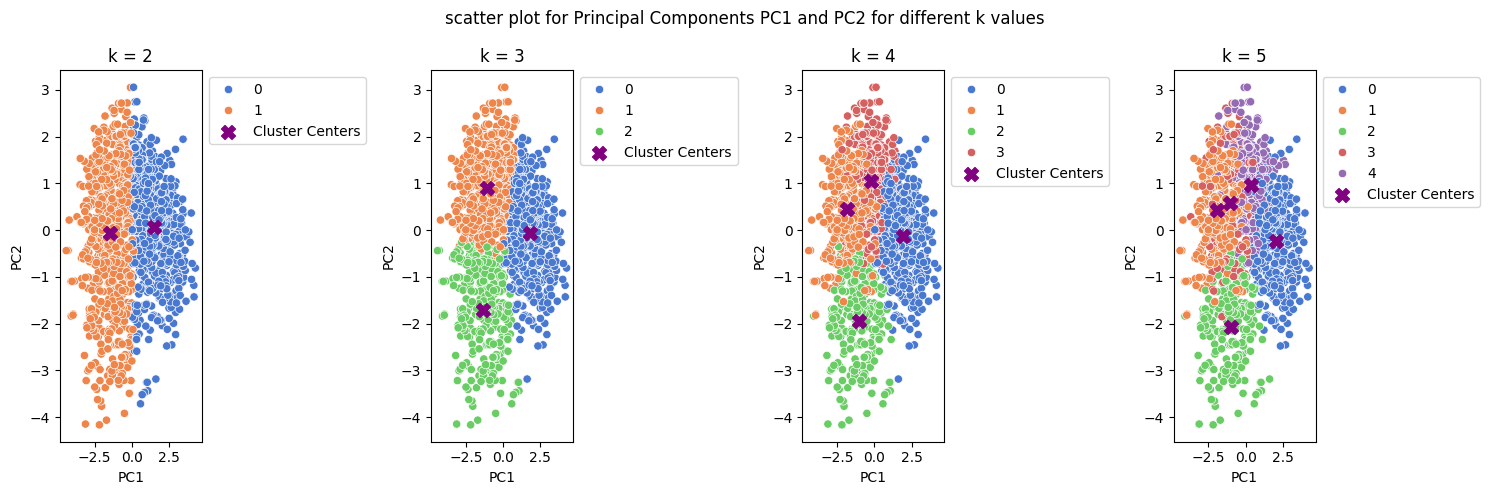

In [22]:
_,axes = plt.subplots(nrows=1,ncols=4,figsize=(15,5),layout='tight')
for i,k in enumerate([2,3,4,5]):
  kmeans_pca = KMeans(n_clusters=k,random_state = 42)
  kmeans_pca.fit(X_pca)
  column_names = ['PC'+str(i+1) for i in range(X_pca.shape[1])]
  scores_df = pd.DataFrame(X_pca,columns=column_names)
  scores_df['cluster'] = kmeans_pca.predict(X_pca)
  axe = sns.scatterplot(
      x='PC1',
      y='PC2',
      data=scores_df,
      hue='cluster',
      ax = axes[i],
      palette=sns.color_palette("muted")
      )
  cluster_centers = kmeans_pca.cluster_centers_
  axe.scatter(cluster_centers[:,0],cluster_centers[:,1],marker='X',s=100,c='purple', label = 'Cluster Centers')
  axe.legend(loc='upper left', bbox_to_anchor=(1, 1))
  axe.set_title(f'k = {k}')
plt.suptitle('scatter plot for Principal Components PC1 and PC2 for different k values')
plt.show()

With 2 clusters we have clear boundaries with 2 dense clusters, although 3 clusters also looks good. But we will trust the silhoutte score

In [24]:
# In order to create a cohort of songs, we will need to relate the scatter plot to the original variables.
#Loading = Eigenvector * √(Eigenvalue)
eigen_vectors = pca.components_.T # Eigen Vector :is the transpose of pca.components_
print('Eigen Vectors\n',pd.DataFrame(eigen_vectors))
eigen_values = pca.explained_variance_ # Eigen Value : is the pca.explained_variance_ for each component
print('\neigen values\n',pd.DataFrame(eigen_values))
loadings  = eigen_vectors * np.sqrt(eigen_values)
loadings_df = pd.DataFrame(loadings,columns=['PC1', 'PC2','PC3','PC4','PC5','PC6', 'PC7'],
                         index=scaled_df.columns )

print('\nLoadings Dataframe:\n')
loadings_df




Eigen Vectors
            0         1         2         3         4         5         6
0  -0.168968 -0.486833  0.141745  0.106319  0.035665  0.606391  0.517320
1  -0.406735  0.264024  0.144918 -0.204817 -0.174714  0.262165  0.042591
2   0.427742  0.367588  0.146972 -0.132142 -0.111967  0.156336  0.128971
3   0.040245  0.156534  0.072647  0.873204 -0.423584  0.093721 -0.081068
4   0.439532 -0.115753 -0.073989 -0.050398 -0.234176  0.006884  0.179626
5   0.365800  0.221658  0.429824 -0.097862 -0.013958  0.015140  0.091188
6   0.369448 -0.000101 -0.165262 -0.151104 -0.004104  0.622009 -0.326480
7   0.194258  0.227343 -0.250721  0.329727  0.737192  0.016903  0.316662
8  -0.258665  0.563425  0.110591 -0.083063 -0.067791  0.067182  0.419023
9  -0.094606 -0.002739  0.664608  0.126121  0.411981  0.140069 -0.425082
10  0.210594 -0.319358  0.444634 -0.018006 -0.058458 -0.344592  0.321931

eigen values
           0
0  3.071038
1  1.611388
2  1.321478
3  1.006515
4  0.914489
5  0.721732
6  0.69860

PC1       PC2       PC3       PC4       PC5       PC6  \
acousticness     -0.296106 -0.617988  0.162944  0.106664  0.034106  0.515159   
danceability     -0.712778  0.335154  0.166591 -0.205483 -0.167077  0.222722   
energy            0.749591  0.466617  0.168952 -0.132572 -0.107072  0.132815   
instrumentalness  0.070527  0.198705  0.083512  0.876044 -0.405069  0.079620   
liveness          0.770252 -0.146938 -0.085055 -0.050562 -0.223940  0.005848   
loudness          0.641041  0.281374  0.494106 -0.098180 -0.013348  0.012862   
speechiness       0.647435 -0.000128 -0.189977 -0.151596 -0.003925  0.528427   
tempo             0.340425  0.288590 -0.288218  0.330800  0.704969  0.014360   
valence          -0.453295  0.715215  0.127131 -0.083333 -0.064828  0.057074   
popularity       -0.165791 -0.003476  0.764004  0.126531  0.393973  0.118995   
duration_ms       0.369053 -0.405394  0.511132 -0.018065 -0.055903 -0.292748   

                       PC7  
acousticness      0.432391  
danceability      0.035599  
energy            0.107798  
instrumentalness -0.067759  
liveness          0.150136  
loudness          0.076218  
speechiness      -0.272881  
tempo             0.264675  
valence           0.350231  
popularity       -0.355296  
duration_ms       0.269079

Scatter plot to examine the influence of features on the Principal Components


Feature Loading on PC1
 liveness            0.770252
energy              0.749591
speechiness         0.647435
loudness            0.641041
duration_ms         0.369053
tempo               0.340425
instrumentalness    0.070527
popularity         -0.165791
acousticness       -0.296106
valence            -0.453295
danceability       -0.712778
Name: PC1, dtype: float64

Feature Loading on PC2
 valence             0.715215
energy              0.466617
danceability        0.335154
tempo               0.288590
loudness            0.281374
instrumentalness    0.198705
speechiness        -0.000128
popularity         -0.003476
liveness           -0.146938
duration_ms        -0.405394
acousticness       -0.617988
Name: PC2, dtype: float64


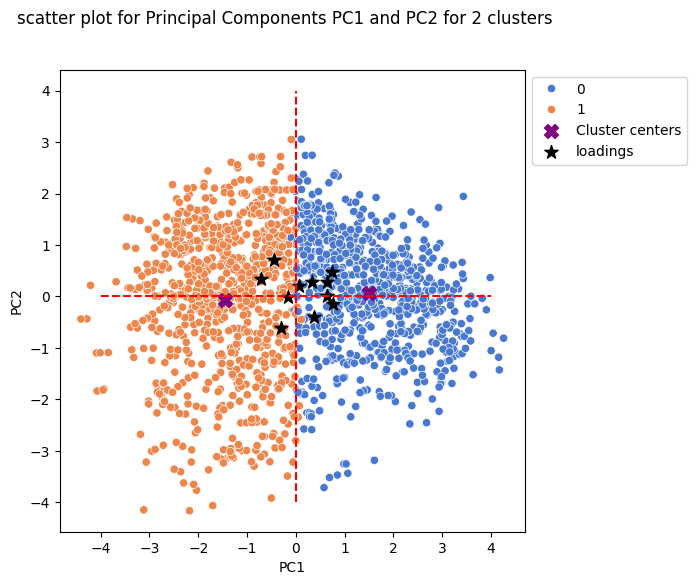

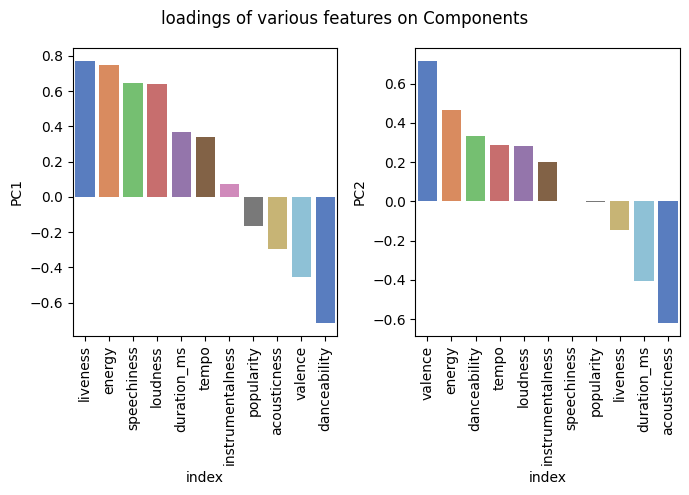


Feature Loading on PC3
 popularity          0.764004
duration_ms         0.511132
loudness            0.494106
energy              0.168952
danceability        0.166591
acousticness        0.162944
valence             0.127131
instrumentalness    0.083512
liveness           -0.085055
speechiness        -0.189977
tempo              -0.288218
Name: PC3, dtype: float64


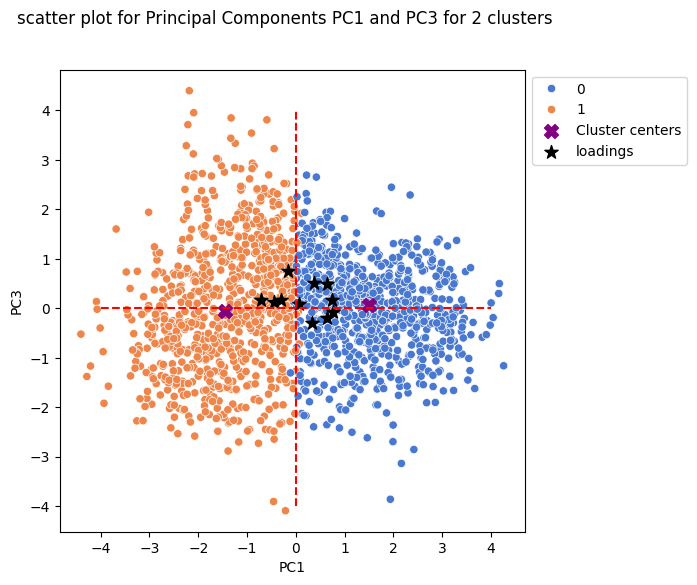

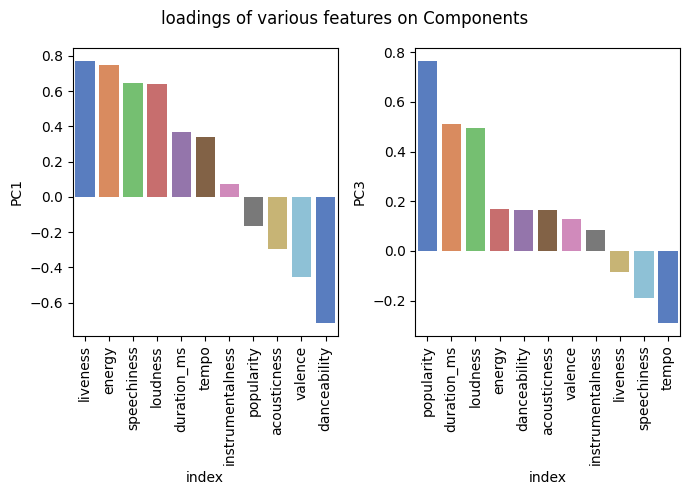


Feature Loading on PC4
 instrumentalness    0.876044
tempo               0.330800
popularity          0.126531
acousticness        0.106664
duration_ms        -0.018065
liveness           -0.050562
valence            -0.083333
loudness           -0.098180
energy             -0.132572
speechiness        -0.151596
danceability       -0.205483
Name: PC4, dtype: float64


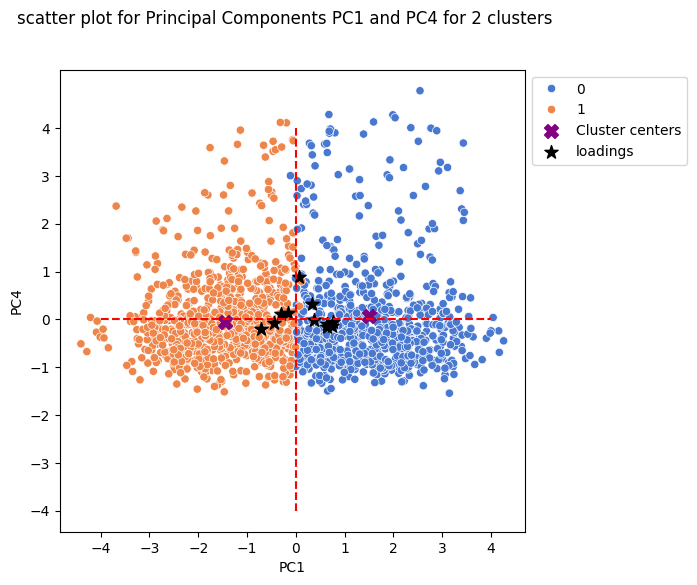

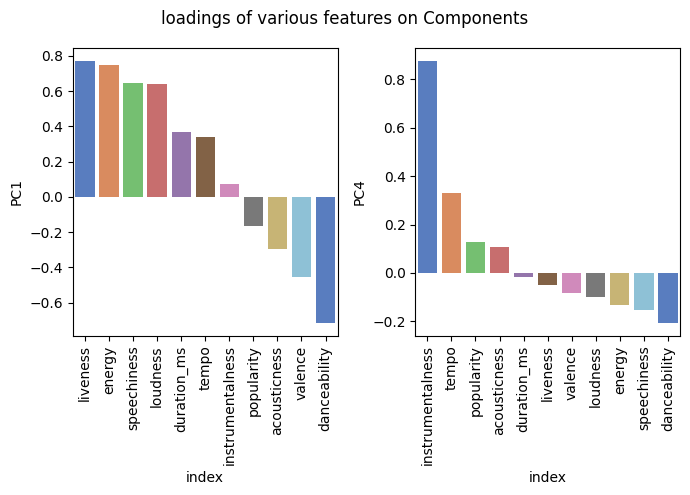


Feature Loading on PC5
 tempo               0.704969
popularity          0.393973
acousticness        0.034106
speechiness        -0.003925
loudness           -0.013348
duration_ms        -0.055903
valence            -0.064828
energy             -0.107072
danceability       -0.167077
liveness           -0.223940
instrumentalness   -0.405069
Name: PC5, dtype: float64


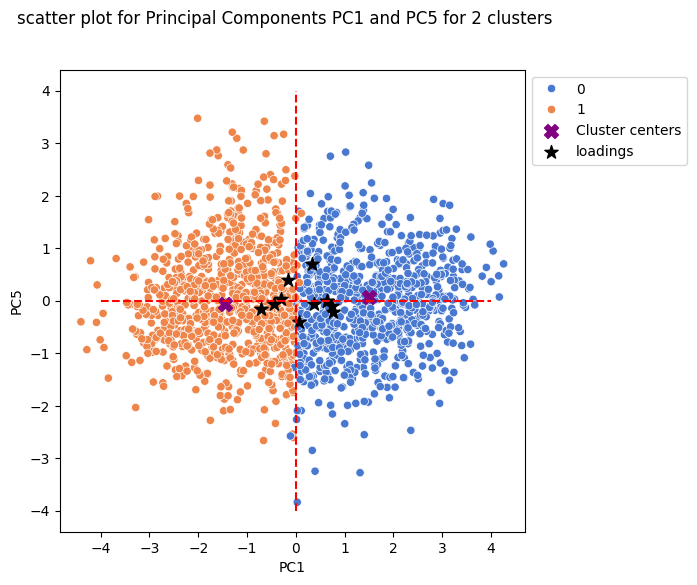

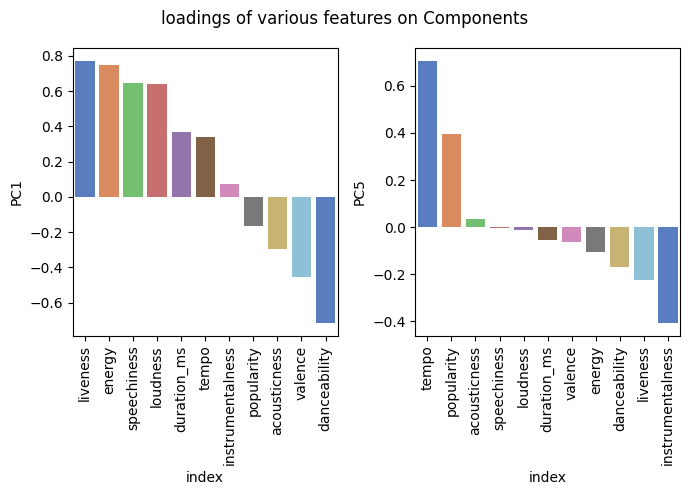


Feature Loading on PC6
 speechiness         0.528427
acousticness        0.515159
danceability        0.222722
energy              0.132815
popularity          0.118995
instrumentalness    0.079620
valence             0.057074
tempo               0.014360
loudness            0.012862
liveness            0.005848
duration_ms        -0.292748
Name: PC6, dtype: float64


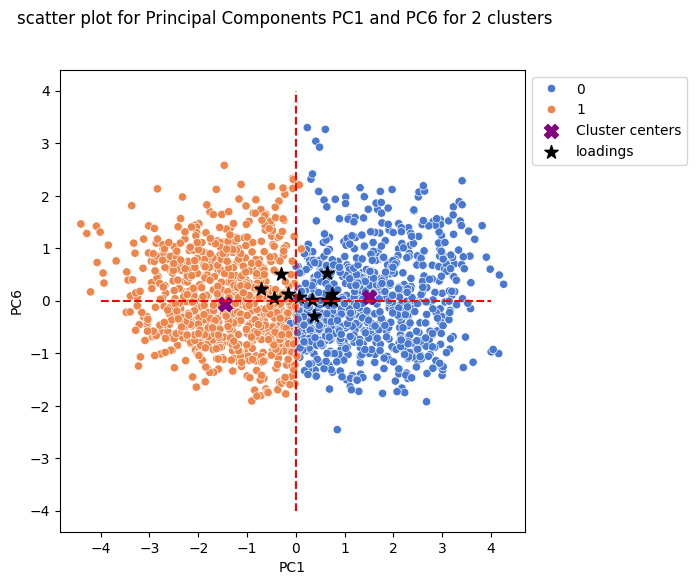

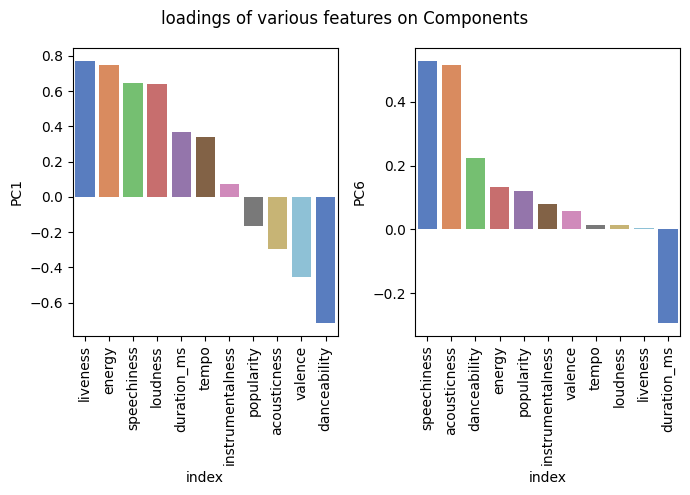


Feature Loading on PC7
 acousticness        0.432391
valence             0.350231
duration_ms         0.269079
tempo               0.264675
liveness            0.150136
energy              0.107798
loudness            0.076218
danceability        0.035599
instrumentalness   -0.067759
speechiness        -0.272881
popularity         -0.355296
Name: PC7, dtype: float64


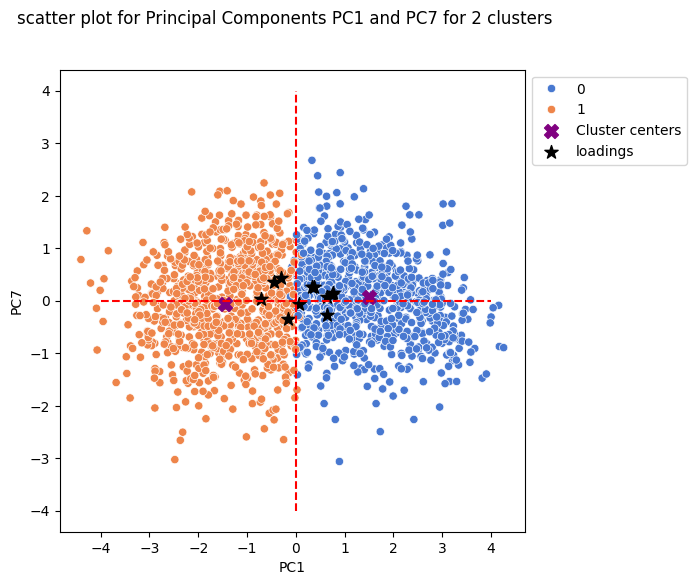

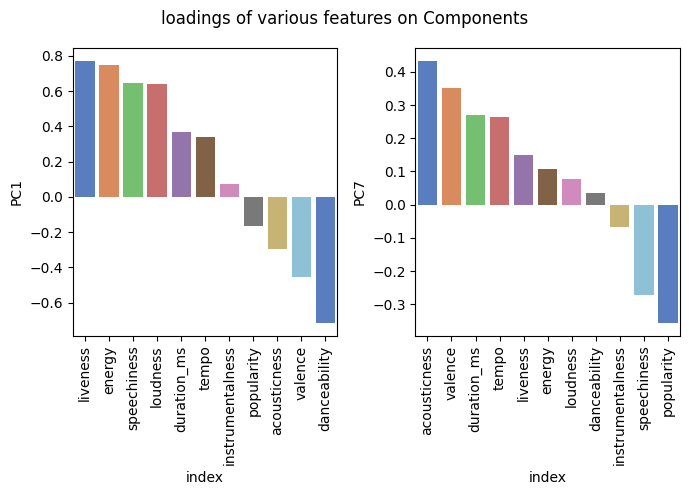

In [25]:
def do_cluster_analysis(comp1,comp2,loadings):
  kmeans_pca = KMeans(n_clusters=2
                      ,random_state = 42)
  kmeans_pca.fit(X_pca)
  column_names = ['PC'+str(i+1) for i in range(X_pca.shape[1])]
  scores_df = pd.DataFrame(X_pca,columns=column_names)
  scores_df['cluster'] = kmeans_pca.predict(X_pca)
  plt.figure(figsize=(6,6))
  axe = sns.scatterplot(
      x=comp1,
      y=comp2,
      data=scores_df,
      hue='cluster',
      palette=sns.color_palette("muted")
      )
  cluster_centers = kmeans_pca.cluster_centers_
  axe.scatter(cluster_centers[:,0],cluster_centers[:,1],marker='X',s=100,c='purple', label = 'Cluster centers')
  axe.scatter(loadings[comp1],loadings[comp2],marker='*',s=100,c='black',label='loadings')


  axe.legend(loc='upper left', bbox_to_anchor=(1, 1))
  axe.plot([-4,0,4],[0,0,0], linestyle='--',color='red')
  axe.plot([0,0,0],[-4,0,4], linestyle='--',color='red')
  plt.xticks(np.arange(-4, 5, 1))
  plt.yticks(np.arange(-4, 5, 1))
  plt.suptitle(f'scatter plot for Principal Components {comp1} and {comp2} for 2 clusters')

  fig,ax = plt.subplots(nrows=1,ncols=2,figsize=(7,5),layout='tight')
  for i,comp in enumerate(loadings.columns):
    comp_loading = pd.DataFrame(loadings.sort_values(by=comp,ascending=False)[[comp]]).reset_index()
    bars = sns.barplot(data = comp_loading,x='index',y=comp,ax=ax[i],palette=sns.color_palette("muted"))
    xticks = bars.get_xticklabels()
    bars.set_xticks(bars.get_xticks())
    bars.set_xticklabels(xticks, rotation=90)
  plt.suptitle('loadings of various features on Components')
  plt.tight_layout()
  plt.show()

#['PC3','PC4'],['PC5','PC6'] do not produce any identifyable clusters.
#Only groups that has PC1 produce meaningful clusters
comp_grps = [['PC1','PC2'],['PC1','PC3'],['PC1','PC4'],['PC1','PC5'],['PC1','PC6'],['PC1','PC7']]

print(f'\nFeature Loading on PC1\n',loadings_df.sort_values(by='PC1',ascending=False)['PC1'])
for comp in comp_grps:
  loadings = loadings_df.loc[:,[comp[0],comp[1]]]
  print(f'\nFeature Loading on {comp[1]}\n',loadings.sort_values(by=comp[1],ascending=False)[comp[1]])
  do_cluster_analysis(comp[0],comp[1],loadings)

 We can see the clusters(Cohorts) having the following characteristics. In defining  characteristics, We will pick the feature that has the maximum influence on a component

**cohort_1(PC1)**<br>
* liveness :       0.770252

From the dictionary, the above loadings indiacate that this cohort will consist of live performance songs

**cohort_2<br>**
* valence    :         0.715215

From the dictionary, the above loadings indicate that this cohort will consist of cheerful , positve and happy songs

**cohort_3(PC3)**<p>
* popularity :         0.764004


This cohort will contain popular songs

**cohort_4**<br>
* instrumentalness :   0.876044

This cohort will mainly consist of instrumentals with minimum spoken content(speechiness = -0.151596)

**cohort_5(PC5)**<br>
*  tempo       :        0.704969

This cohort will contain fast paced , racy songs

**cohort_6(PC6)**<br>
* speechiness     :    0.528427
 This cohort will contain songs that has spoken content(vocals , rap etc)

**Cohort_7**<br>
*   acousticness :        0.43239
*   valence    :          0.350231

This is ignored








**Cohorts of songs**




  

In [ ]:
# combine the original songs data with scores data
combined_df = pd.concat([songs_data,scores_df],axis=1)
combined_df.head()

name               album  track_number  \
0   Concert Intro Music - Live  Licked Live In NYC             1   
1   Street Fighting Man - Live  Licked Live In NYC             2   
2           Start Me Up - Live  Licked Live In NYC             3   
3  If You Can't Rock Me - Live  Licked Live In NYC             4   
4            Don’t Stop - Live  Licked Live In NYC             5   

   acousticness  danceability    energy  instrumentalness  liveness  loudness  \
0     -0.739913     -0.041343  1.127016         -0.346610  1.261552 -2.178321   
1      0.839405     -1.007963  0.967267          2.299562  1.344648  0.743649   
2      0.745875     -0.584626  0.990089          4.315117  1.330321  0.695730   
3      1.418399     -0.704571  1.081373         -0.511270  1.155532  0.479915   
4      0.674614     -1.170242  0.990089          0.162107  1.358975  0.637363   

   speechiness  ...  popularity  duration_ms       PC1       PC2       PC3  \
0     1.636763  ...    0.982999    -2.640778  0.893774 -0.479294 -1.994793   
1     0.525524  ...    1.063495     0.137324  2.105459 -0.582241  0.992444   
2     1.799701  ...    1.063495     0.272974  2.511022 -0.177357  1.031047   
3    -0.279392  ...    0.902504     0.853225  1.711360 -1.850508  1.079908   
4     1.082773  ...    0.902504     0.842712  2.578793 -1.401900  0.816448   

        PC4       PC5       PC6       PC7  cluster  
0 -0.329450  0.272561  1.561165 -3.062564        0  
1  2.267278 -0.506576  0.988107 -0.337824        0  
2  3.722843 -1.485844  1.977501 -0.933280        0  
3  0.001227  0.674244  0.349217  0.429021        0  
4  0.334979  0.314642  0.695236 -0.361126        0  

[5 rows x 22 columns]

In [ ]:
# features influencing principal components are listed in order (pc1 t pc6)
cohort_features = ['liveness', 'valence', 'popularity', 'instrumentalness', 'tempo', 'speechiness']

for index,feature in enumerate(cohort_features):
  cohort = combined_df.sort_values(by=feature,ascending=False).head(100).\
  loc[:,['name','album','track_number']].to_csv(f'cohort{index+1}.csv')

print('{} cohorts of songs created '.format(index+1))

6 cohorts of songs created 
